In [1]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

In [2]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = ['Linux Libertine O']

In [3]:
pd.set_option('max_colwidth', 800)

In [4]:
model = SentenceTransformer('paraphrase-distilroberta-base-v2')

In [5]:
df = pd.read_csv("data/glassdoor/glassdoor_data.csv", 
                 sep = ",", low_memory = False).drop_duplicates()
df = df[~df['company_name'].eq('ycma')]

In [6]:
pride = [
    "I am proud to work for this firm.",
    "People respect what this firm does.",
    "I am proud to be associated with this firm.",
    "I am proud of what this firm accomplishes.",
]

pride_cons = [
    "I am displeased to work for this firm.",
    "People look down upon what this firm does.",
    "I am displeased to be associated with this firm.",
    "I am dissatisfied with how this firm accomplishes what it does.",
]

safety_pros = [
    "Members of this team are able to bring up problems and tough issues.",
    "It is safe to take a risk on this team.",
    "Everyone on this team would act in a supportive manner towards my efforts.",
    "Working with members of this team, my unique skills and talents are valued and utilized.",
]

safety_cons = [
    "If you make a mistake on this team, it is often held against you.",
    "People on this team sometimes reject others for being different.",
    "It is difficult to ask other members of this team for help.",
]

new_vars = [
    'OP_1',
    'OP_2',
    'OP_3',
    'OP_4',
    'PS_1',
    'PS_2',
    'PS_3',
    'PS_4',
    'LOP_1',
    'LOP_2',
    'LOP_3',
    'LOP_4',
    'LPS_1',
    'LPS_2',
    'LPS_3',
]

In [7]:
new_defs = pride + safety_pros + pride_cons + safety_cons
var_def = dict(zip(new_vars, new_defs))

In [8]:
new_def_embeddings = model.encode(new_defs)

In [9]:
cosine_similarity(
    new_def_embeddings,
    model.encode([''])
)

array([[0.20764357],
       [0.16145764],
       [0.21581739],
       [0.237678  ],
       [0.17907487],
       [0.11640394],
       [0.13559271],
       [0.16542208],
       [0.08707327],
       [0.17324612],
       [0.12102549],
       [0.14416708],
       [0.14592561],
       [0.10489625],
       [0.1691471 ]], dtype=float32)

# Calculating OP, PS, and LPS scores

In [10]:
with open('pro_embeddings.pkl', 'rb') as f:
    pro_rev_embeddings = pickle.load(f)

with open('con_embeddings.pkl', 'rb') as f:
    con_rev_embeddings = pickle.load(f)

In [11]:
pro_similarity = cosine_similarity(
    new_def_embeddings,
    pro_rev_embeddings
)

con_similarity = cosine_similarity(
    new_def_embeddings,
    con_rev_embeddings
)

In [12]:
PRO_REVIEW_THRESHOLDS = pro_similarity.mean(axis=1)[:8]
PRO_REVIEW_THRESHOLDS_MEAN = PRO_REVIEW_THRESHOLDS.mean()

CON_REVIEW_THRESHOLDS = con_similarity.mean(axis=1)[8:]
CON_REVIEW_THRESHOLDS_MEAN = CON_REVIEW_THRESHOLDS.mean()

In [13]:
pro_df = pd.DataFrame(pro_similarity.T, columns=new_vars).iloc[:,:8]
# Only keep similarity values for reviews that are above the thresholds
pro_df = pro_df.gt(
    np.maximum(PRO_REVIEW_THRESHOLDS, PRO_REVIEW_THRESHOLDS_MEAN)
).astype(int) * pro_df

pro_df = pd.concat([
    pro_df,
    df[['company_name', 'employee_title', 'pros', 'state', 'year']]
], axis=1).rename({'pros': 'review'}, axis=1)

In [14]:
pro_company = pro_df.groupby('company_name')[new_vars[:8]].mean()

In [15]:
con_df = pd.DataFrame(con_similarity.T, columns=new_vars).iloc[:,8:]
# Only keep similarity values for reviews that are above the thresholds
con_df = con_df.gt(
    np.maximum(CON_REVIEW_THRESHOLDS, CON_REVIEW_THRESHOLDS_MEAN)
).astype(int) * con_df

con_df = pd.concat([
    con_df,
    df[['company_name', 'employee_title', 'cons', 'state']]
], axis=1).rename({'cons': 'review'}, axis=1)

In [16]:
con_company = con_df.groupby('company_name')[new_vars[8:]].mean()

In [17]:
combined = pd.concat([
    pro_df.rename({'review': 'pros'}, axis=1),
    con_df.rename({'review': 'cons'}, axis=1).drop(['company_name', 'state'], axis=1)
], axis=1)

In [18]:
combined.query('OP_1 > 0.5 and LOP_1 > 0.5')[['pros', 'cons']].head(10)

,pros,cons
1373,great company to work for and great pay scale,"not really, i am happy with my employer"
17765,Nice company to work for or at,No room for promotion at this company
35335,Good company to work for. I was there for 18 years.,But when the down turn came in they were not pleasant to work for. They let me go for reasons that were not even there. I expected to retire from there but when the economy turn down and business was slow they started letting people go for unexplainable reasons. I was very disappointed with the company after giving my all for so long.
44443,I was a Telemarketing representative for Trully Clean Air. I enjoyed my job and loved my customers.,"My boss was very ornery and wanted me to show disrespect towards the customers, so I thanked her for her employment but however, that was not how I conduct business and gave her my resignation."
46038,Fun company to work for.,No career path with this company.
48032,Great overall company... great pay and benefits,"Left the company due to a horrible supervisor... he led by intimidation. Company should realize he is a liability. However, he has been there for about 15 years. Makes one question the company's core values."
52353,Good Company to work for,"At the same time, bad company to work for."
55634,Good benefits Fame of the company,IT is not good dept to work at this company
58985,Liked my co workers. Liked working for a strong brand.,I was salaried and they worked us too much with no overtime. Hourly front desk given no breaks. Unfair treatment and lack of respect for employees by this management company.
65002,"Great benefits, good company to work for, you're in control of how much you make","the managers in my location were rather clique-y, rude, and mean"


In [19]:
combined.query('PS_1 > 0.4 and LPS_1 > 0.4')[['pros', 'cons']].head(10)

,pros,cons
2033,"Good benefits, young and energetic team",Team is hindered by poor management and overbearing supervisors
5879,Diverse environment; consistent challenges with a fast pace; friendly and inclusive teams; some opportunity for advancement; real-world skills to use in various job markets.,"tant breakdown of communication, team cohesion, and daily goals; lack of support from store leadership; larger focus on finding a person to blame for a job done poorly than a focus to do the job correctly."
9966,"There are always challenges and deadlines, keeps you on your toes so that top individuals can excel in this next level environment.",Current out sourcing rate hurts US morale and impacts overall performance of teams. As members in same team or across working groups were impacted it left discontent in its wake.
20987,Great team willing to work hard. Allows you to explore different areas hit may be interested in. Bonus potential.,Very sales focused. You will often have to pick up the slack for the rest of the team. You may have assigned duties that others are too lazy to Perform.
24411,"WFH, great teamwork, lots of training",They kind of just throw you in
26666,-Very experienced team and management -Challenging projects if you choose them wisely -Possibility of great visibility and valuable work experience,-Goals are sometimes unclear - lack direction and create conflicts -Communication within and outside team can be challenging
27352,AMD culture of cooperation to get it done Can do attitude Launching exciting products,New guys don't get it That new guy leading your team
30783,"Really open and inviting teams, with mentors and peers that pushed me to my limits. I was given as much work as I wanted while always feeling like a significant team contributor",Very complex corporate culture often seems that teams are in competition instead of collaboration
36219,The volatile world of customer support provides a challenging career for a troubleshooter. There are always exciting and interesting problems to stimulate thought. You will find good people willing to offer materials to get you up to speed. There's nothing like observing a couple of outages so you can see the group in action to help you get into the role you have been assigned.,"Most of the people do have a great team mentality. As with any large group there are bound to be a few outliers, unfortunately this is usually in the constantly changing management personnel. They are brought in to quell fires with little time to get to know their team with the thought of 'how many can I cut without hurting the integrity of the team"". You do not want to be there during the transition which seems to..."
38326,Some of the groups are good and aggressive,Some biased decisions are made in certain groups


In [20]:
data = pd.DataFrame({
    'company_name': combined['company_name'],
    'OP': combined[['OP_1', 'OP_2', 'OP_3', 'OP_4']].mean(axis=1),
    'PS': combined[['PS_1', 'PS_2', 'PS_3', 'PS_4']].mean(axis=1),
    'LOP': combined[['LOP_1', 'LOP_2', 'LOP_3', 'LOP_4']].mean(axis=1),
    'LPS': combined[['LPS_1', 'LPS_2', 'LPS_3']].mean(axis=1),
    'pros': combined['pros'],
    'cons': combined['cons'],
    'state': combined['state'],
})

stats = data.groupby('company_name').mean(numeric_only=True)[data.groupby('company_name').size().gt(100)]

In [21]:
baseline = pd.DataFrame(
    np.concatenate([
        data[data['OP'].gt(data['OP'].quantile(.75))].sample(10, random_state=1).pros.values,
        data[data['LOP'].gt(data['LOP'].quantile(.75))].sample(10, random_state=100).cons.values,
        data[data['PS'].gt(data['PS'].quantile(.75))].sample(10, random_state=5).pros.values,
        data[data['LPS'].gt(data['LPS'].quantile(.75))].sample(10, random_state=11).cons.values,
    ]),
    columns=['review']
).assign(category=['OP'] * 10 + ['LOP'] * 10 + ['PS'] * 10 + ['LPS'] * 10)
# baseline.to_csv('data/baseline.csv', index=False)

In [22]:
data[data['PS'].gt(data['PS'].quantile(.75))].sample(10, random_state=5).pros.values

array(['great training and incentive program',
       'Offers professional growth, good co-workers. Ability to telecommute.',
       'Great coworkers, easy uniform, nice managers',
       '-Met some great people. -Good team dynamics.',
       'Great working environment! Amazing customers (for the most part), very good customer service.',
       'I’ve worked many jobs, but I have to give Enterprise a major high five for being a good company. We work hard and we get along. Teamwork is easy because the company has organized a system that is easy to learn and also holds everyone accountable for being reliable. Best off, there is no unnecessary micromanagement, and plenty of incentives are given for doing a job well done.',
       'I loved my team. The reason I stayed at SPP for over a year was because of the people I worked with. They were all amazing, dedicated and smart people. The pay was great for me but I feel that I could have been making the same amount as people who had been there 

In [23]:
baseline = pd.DataFrame(
    np.concatenate([
        data[data['OP'].eq(0)].sample(10, random_state=11).pros.values,
        data[data['LOP'].eq(0)].sample(10, random_state=100).cons.values,
        data[data['PS'].eq(0)].sample(10, random_state=5).pros.values,
        data[data['LPS'].eq(0)].sample(10, random_state=11).cons.values,
    ]),
    columns=['review']
).assign(category=['OP'] * 10 + ['LOP'] * 10 + ['PS'] * 10 + ['LPS'] * 10)
# baseline.to_csv('data/baseline-2.csv', index=False)

In [24]:
from rake_nltk import Rake

all_keywords = []
for concept in [pride, pride_cons, safety_pros, safety_cons]:
    keywords = []
    for construct in concept:
        rake_nltk_var = Rake()
        rake_nltk_var.extract_keywords_from_text(construct)
        keywords.extend(rake_nltk_var.get_ranked_phrases())
    all_keywords.append(np.unique(keywords))

In [25]:
baseline = pd.concat([
    pd.read_csv('data/baseline.csv').assign(label=1),
    pd.read_csv('data/baseline-2.csv').assign(label=0)
])

In [26]:
# from sklearn.metrics import classification_report

# print(classification_report(baseline.dropna()['Average'], baseline.dropna()['label']))

In [27]:
# print(classification_report(baseline.dropna()['Average'], baseline.dropna()['Keyword-based']))

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

y_preds = []
for vocab in all_keywords:
    vec = CountVectorizer(binary=True, vocabulary=vocab)
    X = vec.fit_transform(baseline['review'])
    y_preds.append(
        np.array(X.sum(axis=1)).flatten()
    )

In [29]:
p = data.groupby('state').agg({
    'OP': 'mean',
    'PS': 'mean',
    'LOP': 'mean',
    'LPS': 'mean',
})

In [30]:
from sklearn.decomposition import PCA

pca = PCA(2)
stats_pca = pca.fit_transform(stats)
pca.explained_variance_ratio_.cumsum()

array([0.58162672, 0.87024331])

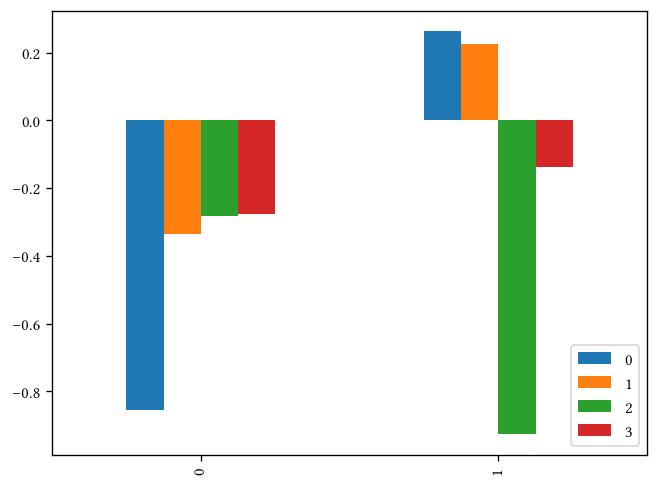

In [31]:
pd.DataFrame(pca.components_).plot.bar();

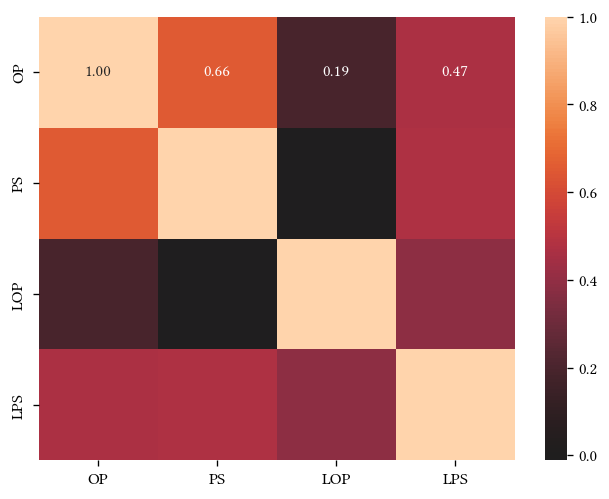

In [32]:
sns.heatmap(
    stats.corr(),
    center=0,
    annot=True,
    fmt='.2f'
);

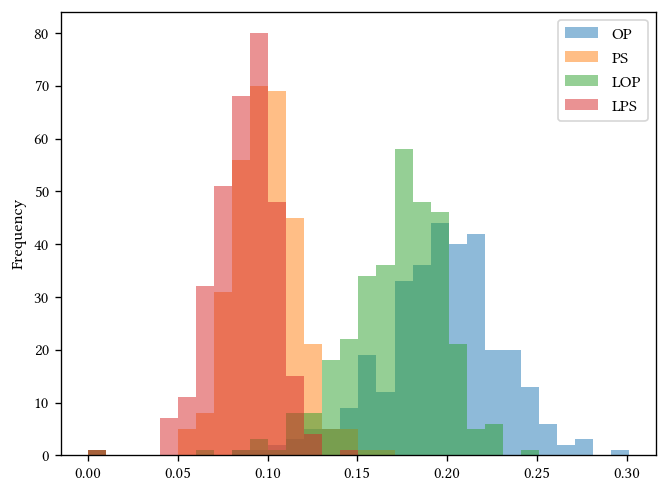

In [33]:
stats.plot.hist(bins=30, alpha=.5);

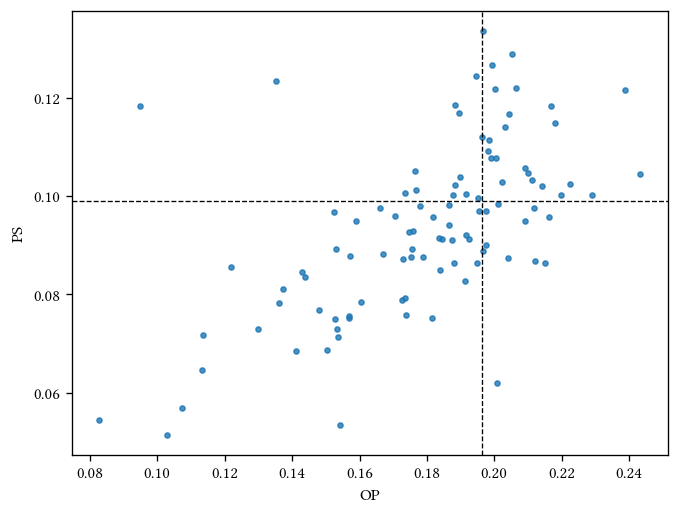

In [34]:
plt.scatter(
    x='OP',
    y='PS',
    data=stats.assign(n_reviews=data.groupby('company_name').size()).nlargest(100, 'n_reviews'),
    marker='.',
    alpha=.8,
)
plt.axvline(stats['OP'].mean(), linestyle='--', c='k', linewidth=.8)
plt.axhline(stats['PS'].mean(), linestyle='--', c='k', linewidth=.8)
plt.xlabel('OP')
plt.ylabel('PS');

In [35]:
df.query('company_name == "dominos"')[['pros', 'cons']]

,pros,cons
27808,"Some nights $100+ in tips Discount on food Free food anytime an order is messed up or never picked up If you work in an upper class area, tips are probably better",Puts miles on your vehicle Some nights are rough when there are lots of orders and nobody seems to be tipping
27809,They teach great life skills and a good work ethic.,"Hours are not always the best, but that is apart of the pizza buisness"
27810,Flexible schedules are available if necessary,Has a toxic environment that makes employees not want to stay long
27811,"Easy work, always around food, fun co-workers, fast paced, jamming out in the car, get paid in cash when you leave.","Staying until 1:00 am sometimes is a hassle, but is to be expected if you are a closer"
27812,Great associates help program and benefits not to mention half-off all menu items for workers.,Certain locations in Dallas are know to be hit up by armed robbers multiple times a year my store was one of them. And the company starts you out at the lowest rate possible where even some shift managers are making just about nine dollars an hour. It's sad because they (the company) have the funds to pay more but just doesn't.
...,...,...
439087,Good pay Light work Laid back team Easy to pick up hours,Some employees react poorly to kitchen stress and create a toxic environment in the kitchen during rushes
439088,The pros of working at Domino's was that everyone got one free meal and the people there were so nice like a family.,The cons of working at Domino's was that they couldn't give me more hours due to my age and it felt like there was not much room to grow
439089,"Pretty good tips and decent wage between hourly wage and tips. If you are a night owl like me, the hours you work are fun.","Short shifts are tough. If you aren't busy, sometimes you can come in for two-four hours and then go home. This improves as you move up in more full-time work, however."
439090,It's a lax workplace. When the store is busy everyone gets hard to work and when all the work is done during a slow time everyone is happy to just kick back. Great GM who worked his way up and knows the business.,There aren't many downsides other than the constant employee turnover. In my short time there i saw at least 9 employees come and go. The constant training and new employees slows the store and hurts quality.


In [36]:
stats.query('LPS > 0.11 & PS < 0.10')

,OP,PS,LOP,LPS
company_name,,,,
americanexpress,0.211748,0.097507,0.178434,0.111756
ameriprise,0.202771,0.093868,0.191088,0.110229
capitalone,0.191878,0.092922,0.159156,0.113463
cmegroup,0.190353,0.093547,0.195846,0.110792
elililly,0.222265,0.099529,0.182106,0.111916
moodys,0.181599,0.099883,0.179418,0.123311
nobleenergy,0.197444,0.089127,0.242125,0.120726
paypal,0.186583,0.094048,0.182144,0.120646


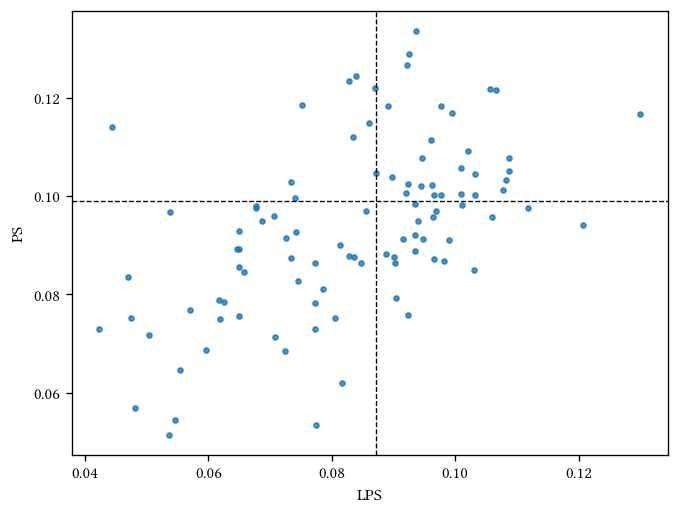

In [37]:
plt.scatter(
    x='LPS',
    y='PS',
    data=stats.assign(n_reviews=data.groupby('company_name').size()).nlargest(100, 'n_reviews'),
    marker='.',
    alpha=.8,
)
plt.axvline(stats['LPS'].mean(), linestyle='--', c='k', linewidth=.8)
plt.axhline(stats['PS'].mean(), linestyle='--', c='k', linewidth=.8)
plt.xlabel('LPS')
plt.ylabel('PS');

# Company Ratings

In [38]:
company_df = df[['company_name', 'Region', 'Division', 'GICSSector', 'GICSSubIndustry', 'Headquarters Location']].drop_duplicates()

In [39]:
company_df = df.groupby('company_name').agg({
    'GICSSector': ['first', 'size'],
    'rating_balance': 'mean',
    'rating_career': 'mean',
    'rating_comp': 'mean',
    'rating_culture': 'mean',
    'rating_mgmt': 'mean',
    'rating_overall': 'mean',
}).reset_index()
company_df.columns = [
    'company_name',
    'sector',
    'n_reviews',
    'rating_balance',
    'rating_career',
    'rating_comp',
    'rating_culture',
    'rating_mgmt',
    'rating_overall',
]

In [40]:
company_df = stats.merge(
    company_df,
    how='left',
    on='company_name'
)
company_df = company_df[~company_df['company_name'].eq('ycma')]

In [41]:
company_df['n_reviews'].sum()

430788

In [42]:
company_df['n_reviews'].sum() / df.shape[0]

0.9911055690273183

To get the OP & PS scores, we first take the average score from the four concepts. For example, $\bar{OP}_u$ means the average score from four concepts in OP, i.e.
$$
\bar{OP}_u = \frac{s(u, OP1) + s(u, OP2) + s(u, OP3) + s(u, OP4)}{4}
$$
The same method applies for PS, LOP, and LPS. We then standardize the values per concept category by subtracting the value with the mean and dividing it by the standard deviation to get the so-called z-score as seen in the following.

\begin{align*}
z_{OP,u} &= \frac{\bar{OP}_u - \mu(\bar{OP})}{\sigma(\bar{OP})} \\
z_{PS,u} &= \frac{\bar{PS}_u - \mu(\bar{PS})}{\sigma(\bar{PS})} \\
z_{LOP,u} &= \frac{\bar{LOP}_u - \mu(\bar{LOP})}{\sigma(\bar{LOP})} \\
z_{LPS,u} &= \frac{\bar{LPS}_u - \mu(\bar{LPS})}{\sigma(\bar{LPS})} \\
\end{align*}

Finally, we get the OP \& PS scores for company $u$ by subtracting the z-score from the pro concept category by the con concept category.

\begin{align*}
OP_{\text{score},u} &= z_{OP,u} - z_{LOP,u} \\
PS_{\text{score},u} &= z_{PS,u} - z_{LPS,u}
\end{align*}

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
company_df[['OP', 'PS', 'LOP', 'LPS']] = scaler.fit_transform(company_df[['OP', 'PS', 'LOP', 'LPS']])

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif

In [45]:
calc_vif(company_df[['OP', 'PS', 'LOP', 'LPS']])

,variables,VIF
0,OP,1.924255
1,PS,2.057380
2,LOP,1.290117
3,LPS,1.634297


In [46]:
missing_companies = pd.read_csv('missing.csv').query('sector != "Real Estate"')

In [47]:
company_df = company_df.merge(
    missing_companies,
    how='left',
    on='company_name',
    suffixes=('', '_y')
)
company_df['sector'] = company_df.sector.combine_first(company_df.sector_y)
del company_df['sector_y']

In [48]:
company_df['OP_score'] = company_df['OP'] - company_df['LOP']
company_df['PS_score'] = company_df['PS'] - company_df['LPS']

/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

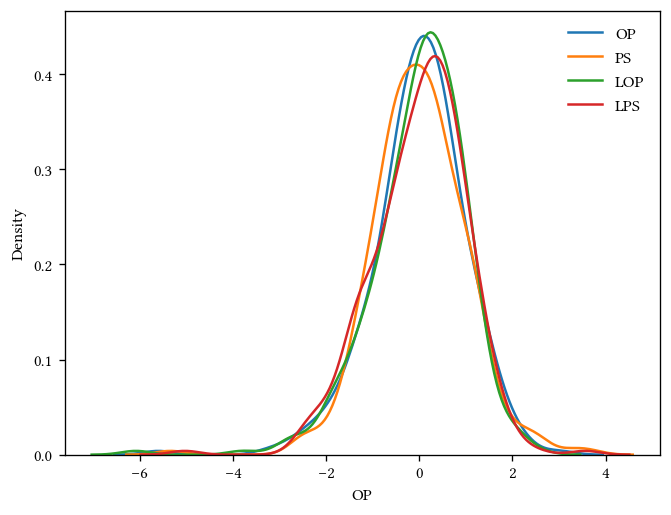

In [49]:
sns.kdeplot(company_df['OP'], label='OP')
sns.kdeplot(company_df['PS'], label='PS')
sns.kdeplot(company_df['LOP'], label='LOP')
sns.kdeplot(company_df['LPS'], label='LPS')
plt.legend(frameon=False);

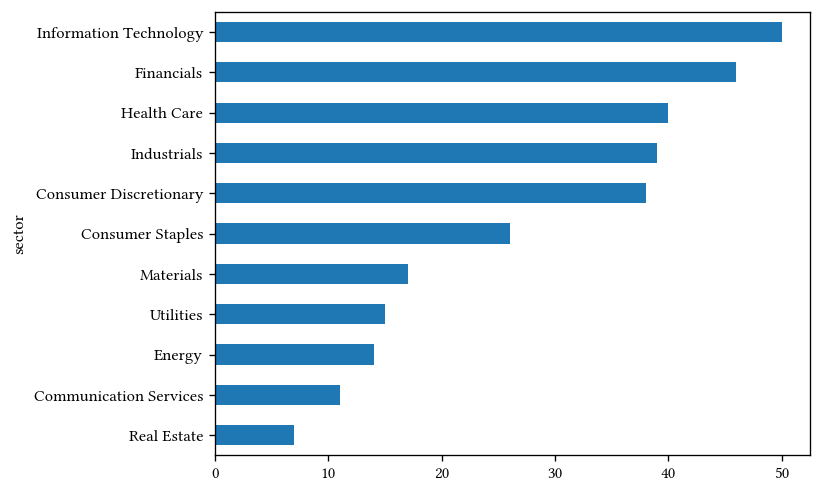

In [50]:
company_df.groupby('sector').size().sort_values().plot.barh();

In [51]:
company_df[['OP_score', 'PS_score', 'rating_overall']].corr()

,OP_score,PS_score,rating_overall
OP_score,1.000000,0.449600,0.792949
PS_score,0.449600,1.000000,0.218947
rating_overall,0.792949,0.218947,1.000000


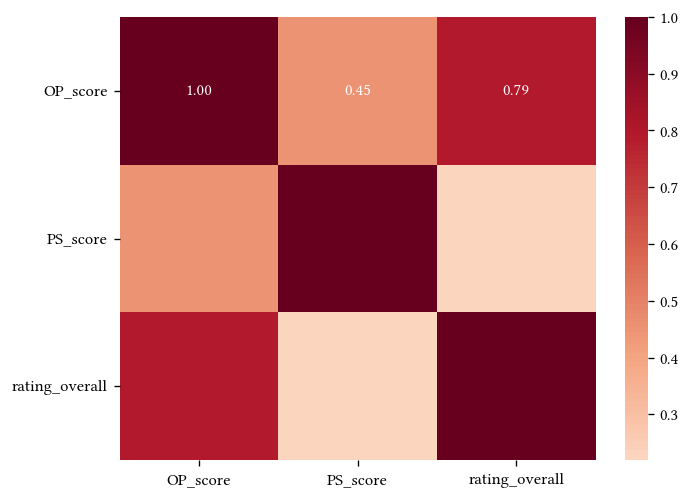

In [52]:
sns.heatmap(
    company_df[['OP_score', 'PS_score', 'rating_overall']].corr(),
    center=0,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r'
)
plt.yticks(rotation=0);

In [53]:
company_df['n_reviews'].sum() / df.shape[0]

0.9911055690273183

In [54]:
# company_df[['OP_score', 'PS_score']] = scaler.fit_transform(company_df[['OP_score', 'PS_score']])

company_df['high_OP'] = company_df.OP_score.gt(0)
company_df['high_PS'] = company_df.PS_score.gt(0)
company_df['quadrant'] = company_df.apply(lambda x: f"{x['high_OP']}-{x['high_PS']}", axis=1)
company_df['quadrant'] = company_df['quadrant'].map({
    'False-False': 'No Designated Leadership',
    'False-True': 'Teams Leadership',
    'True-False': 'Company Leadership',
    'True-True': 'Company and Teams Leadership'
})

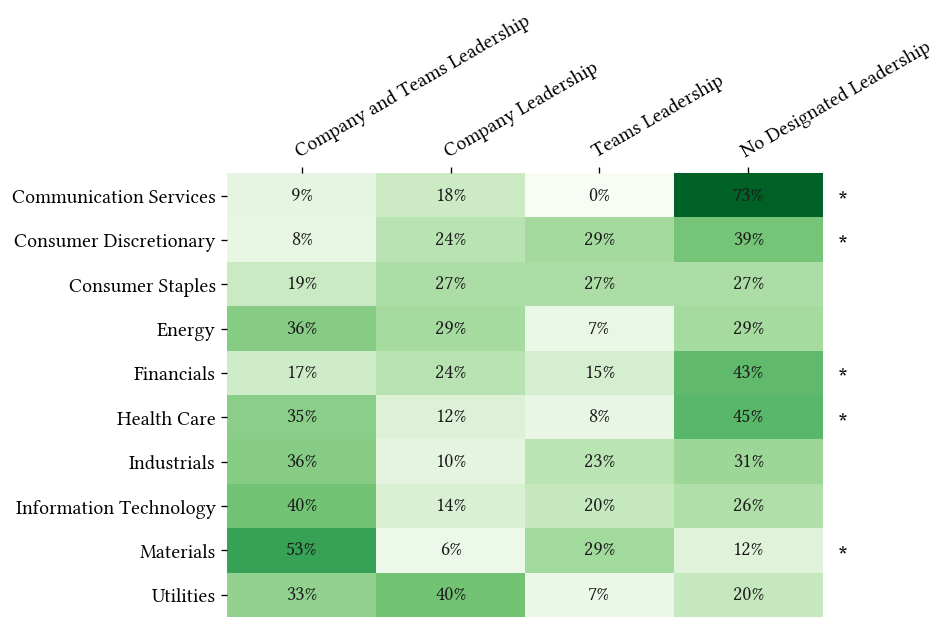

In [211]:
from scipy.stats import chisquare

q = company_df.query('sector != "Real Estate"').pivot_table(
    index='sector',
    columns='quadrant',
    values='company_name',
    aggfunc='size',
    fill_value=0
)

fig, ax = plt.subplots()
columns = ['Company and Teams Leadership', 'Company Leadership', 'Teams Leadership', 'No Designated Leadership']

table = q.divide(q.sum(axis=1), axis=0)[columns]
ax.imshow(table, vmin=0, vmax=0.8, cmap='Greens', aspect='auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(table.columns)), labels=table.columns)
ax.set_yticks(np.arange(len(table.index)), labels=table.index)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=30, ha="left",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(table.index)):
    chi2, pval = chisquare(q.iloc[i].values)
    if pval < 0.05:
        ax.text(3.6, i + 0.3, '*', fontsize=16)
    for j in range(len(table.columns)):
        text = ax.text(j, i, f"{table.iloc[i, j]:.0%}",
                       ha="center", va="center", color="k")

sns.despine(bottom=True, left=True)
# plt.savefig('figures/sector-quadrant-new.pdf', bbox_inches='tight')

In [ ]:
q.iloc[-3].sum()

50

In [ ]:
chisquare(q.iloc[-3].values)

Power_divergenceResult(statistic=7.4399999999999995, pvalue=0.05912031649806231)

In [56]:
# q = company_df.query('sector != "Real Estate"').pivot_table(
#     index='sector',
#     columns='quadrant',
#     values='company_name',
#     aggfunc='size',
#     fill_value=0
# )
# fig, ax = plt.subplots()
# sns.heatmap(
#     q.divide(q.sum(axis=1), axis=0),
#     annot=False,
#     fmt='.0%',
#     # xticklabels=['The Strugglers', 'The Silos', 'The Powerful', 'The Champions'],
#     cmap='Greens',
#     ax=ax
# )
# plt.xlabel('Quadrant')
# plt.ylabel('Sector')
# # plt.xticks(rotation=45)
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()
# ax.xaxis.set_tick_params(rotation=15)
# plt.savefig('figures/sector-quadrant.pdf', bbox_inches='tight')

In [57]:
# Communication Services -> Strugglers
# Consumer Discretionary -> No Champions
# Financials -> Lots of Strugglers
# Health Care -> Either Champions or Strugglers
# Materials -> High PS

In [58]:
input_data = combined.merge(
    company_df[['company_name', 'quadrant']],
    how='left',
    on='company_name'
)
input_data = input_data[input_data['quadrant'].astype('category').cat.codes.ne(-1)]

In [59]:
q_to_i = {
    'No Designated Leadership': 0,
    'Teams Leadership': 1,
    'Company Leadership': 2,
    'Company and Teams Leadership': 3,
}

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 3), max_df=.95, min_df=2, max_features=100, stop_words='english'),
    LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
)
pipe.fit(
    input_data['pros'].fillna('').values,
    input_data['quadrant'].map(q_to_i)
)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.95, max_features=100, min_df=2,
                                 ngram_range=(1, 3), stop_words='english')),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

In [61]:
sns.set_context('talk')

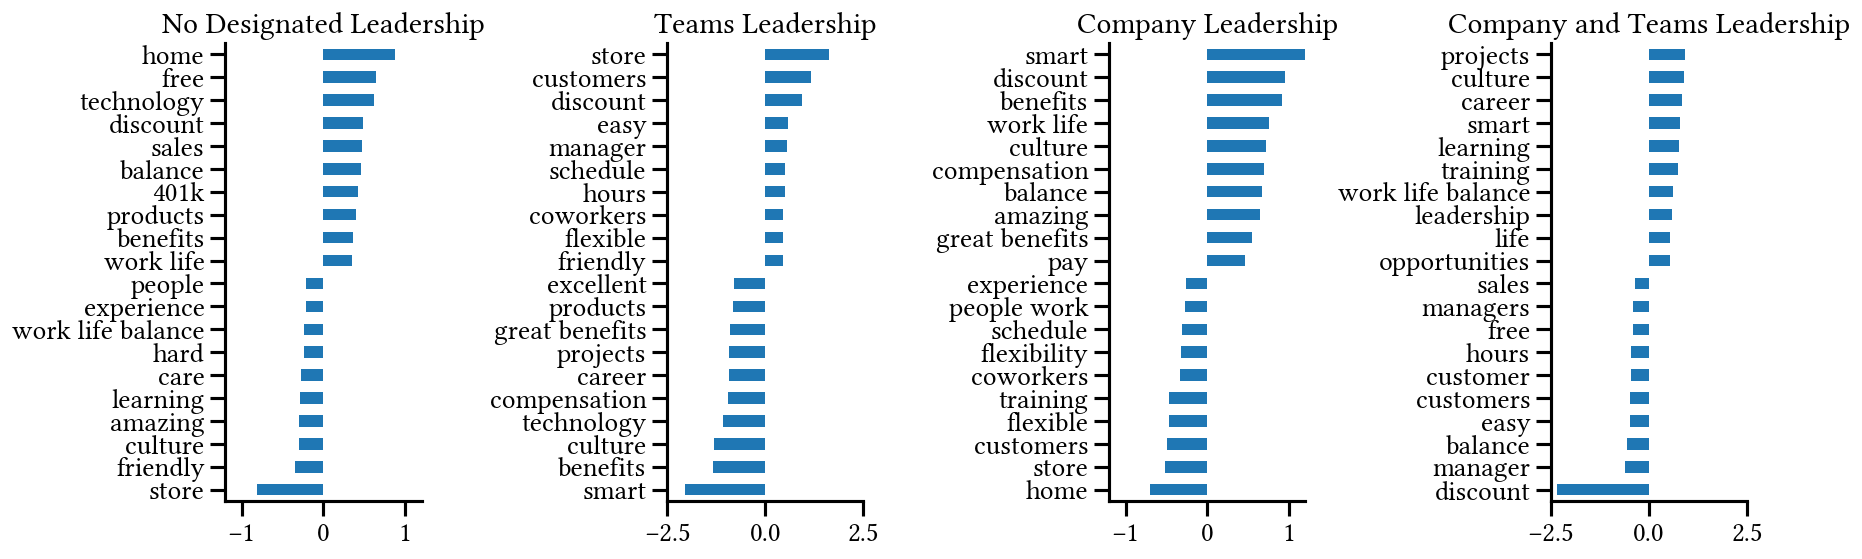

In [62]:
feature_names = pipe[0].get_feature_names_out()

fig, axes = plt.subplots(ncols=4, figsize=(15, 5))
for ax, v, label in zip(axes.flatten(), pipe[1].coef_, q_to_i.keys()):
    # pd.Series(v, index=feature_names).nlargest(10).sort_values().plot.barh(ax=ax[0])
    # pd.Series(v, index=feature_names).nsmallest(10).sort_values().plot.barh(ax=ax[1])
    pd.concat([
        pd.Series(v, index=feature_names).nlargest(10),
        pd.Series(v, index=feature_names).nsmallest(10)
    ]).sort_values().plot.barh(ax=ax)
    if label in ['No Designated Leadership', 'Company Leadership']:
        ax.set_xlim(-1.2, 1.2)
    else:
        ax.set_xlim(-2.5, 2.5)
    ax.set_title(label)

plt.tight_layout()
sns.despine()
plt.savefig('figures/discriminative-keywords.pdf', bbox_inches='tight')

In [63]:
# pd.DataFrame(pipe[1].coef_.T, index=pipe[0].get_feature_names_out()).sort_values(0).plot.barh()

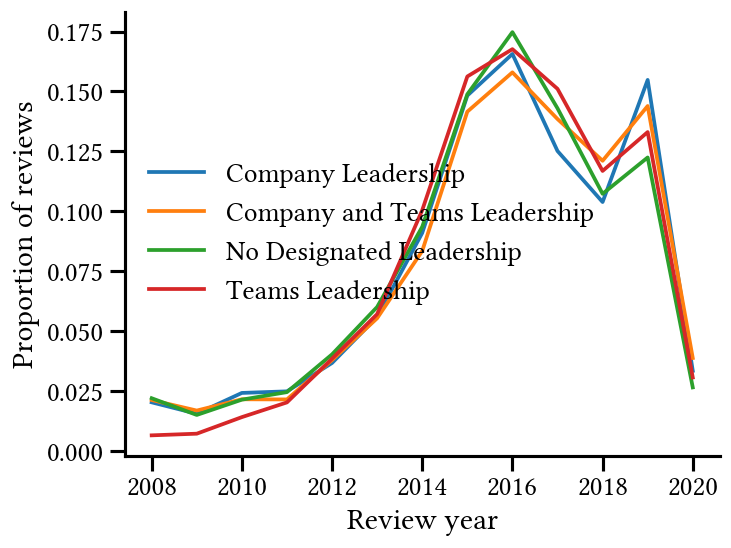

In [64]:
ts = combined.merge(
    company_df[['company_name', 'quadrant']],
    how='left',
    on='company_name'
).pivot_table(
    index='year',
    columns='quadrant',
    values='company_name',
    aggfunc='count'
)

ts.divide(ts.sum(axis=0)).plot.line()
plt.xlabel('Review year')
plt.ylabel('Proportion of reviews')
plt.legend(frameon=False)
sns.despine()

In [65]:
from scipy.stats import chisquare

# f_exp = q.sum(axis=0).values
# f_obs = q.iloc[0]
for sector, f_obs in q.iterrows():
    # pi = q.sum(axis=0) / q.values.sum()
    # f_exp = np.round(f_obs.sum() * pi)
    print(sector, "|", f"{chisquare(f_obs)[1]:.3f}")

Communication Services | 0.003
Consumer Discretionary | 0.048
Consumer Staples | 0.927
Energy | 0.463
Financials | 0.028
Health Care | 0.002
Industrials | 0.121
Information Technology | 0.059
Materials | 0.028
Utilities | 0.269


In [66]:
company_df

,company_name,OP,PS,LOP,LPS,sector,n_reviews,rating_balance,rating_career,rating_comp,rating_culture,rating_mgmt,rating_overall,OP_score,PS_score,high_OP,high_PS,quadrant
0,3m,0.673018,-0.096363,0.137471,0.561093,Industrials,1048,3.502528,3.497965,3.741573,3.559838,3.101415,3.601145,0.535547,-0.657456,True,False,Company Leadership
1,abbott,0.560642,-0.174565,0.950872,0.528178,Health Care,1235,3.198312,3.140000,3.617421,3.025402,2.695560,3.250202,-0.390230,-0.702743,False,False,No Designated Leadership
2,abbvie,0.111844,0.227736,-0.319526,0.955378,Health Care,409,3.261658,3.208877,3.905512,3.288312,3.002688,3.537897,0.431370,-0.727641,True,False,Company Leadership
3,accenture,0.106952,1.221729,-0.497230,1.066282,Information Technology,6057,3.291337,3.649844,3.580966,3.746030,3.329647,3.683011,0.604182,0.155447,True,True,Company and Teams Leadership
4,adobe,1.243496,0.119239,-0.191066,1.645551,Information Technology,842,4.094945,3.618340,4.278261,4.206428,3.554443,4.079572,1.434562,-1.526312,True,False,Company Leadership
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,unitedhealthgroup,-0.841739,-0.583000,0.620649,0.094063,Health Care,5109,3.101954,2.970203,2.988279,3.008172,2.606246,2.967313,-1.462388,-0.677063,False,False,No Designated Leadership
314,ups,-1.312938,-1.633482,-1.775184,-1.594254,Industrials,7901,3.124056,3.416088,3.661353,3.184439,2.900912,3.410834,0.462246,-0.039228,True,False,Company Leadership
315,wallgreens,-1.028487,-1.106429,0.179196,-1.427139,Consumer Staples,8113,2.791699,2.903708,2.936152,2.917967,2.620000,2.985825,-1.207683,0.320710,False,True,Teams Leadership
316,wellsfargo,-0.246171,0.063474,0.231628,0.609469,Financials,5484,3.418311,3.470339,3.547265,3.328591,2.955429,3.394785,-0.477799,-0.545995,False,False,No Designated Leadership


In [67]:
df.query('company_name == "netflix"')[['pros', 'cons']].sample(5)

,pros,cons
127820,"High pay, freedom and responsibility.","Everything else. If you want to work 90 hours a week, have no family life, and still get fired after nothing but glowing reviews, then this place is for you! In my case, I gave direct, actionable feedback about a colleague, and that led to my dismissal. The culture deck says feedback is never used to retaliate - but that's not true at all. So fair warning - if you give someone honest feedback about how to improve in their position, be prepared for that to bite you later on. Politics is real here - people are retained or promoted based on who they know, and people are so routinely fired here, regardless of their performance, that everyone is numb to it. Glad to see my time here coming to an end. If you like playing dirty politics at work, then you've found a good place. If you want psyc..."
127764,I'm working on one of Netflix's most popular animated show right now!,the schedule is a bit crazy. We're only doing 10 episodes rather than 13.
236021,"-$$$$$!!! ($13-$14/hr to start w/full time hours immediately) -Free rental subscription--the highest one they offer (8 @ a time) -Medical/Dental/Vision Insurance available right away -free food in breakroom along with Netflix connection & big screen TV to watch shows -showers in bathrooms if you walk/ride a bike and need to clean up before work -peers are fun to work with -high speed internet & laptops available to check e-mail, facebook, myspace on breaks","-fear-based company -anyone higher up than you will NOT respect you. Period. -cliquish environment (if you're not with the in crowd, you're invisible.) -very poor communication about job performance -do not uphold their own company values -rarely promote from within -contradictions galore! In the nine days I was there for training before being unfairly dismissed, I saw several examples of employees being treated like children and unreasonably scolded. One girl was in the classroom 5 minutes before break was over. She suddenly had a bathroom emergency, so she left quickly to take care of it. She made it back just as they were shutting the door. On the next break, she was taken aside by the supervisor (supe) who said, ""I noticed you made it back from break just as I was shutting the door..."
127756,"- Managers tell you what needs to be done and why, giving you the freedom to decide how to achieve the goals. - Deadlines are reasonable and rarely require late nights or weekends. - Very little process getting in the way of coding. - No junior engineers, no slackers allowed. - Managers are very willing to fire employees who do not get their jobs done or who have bad attitude, so everyone is good at their job and easy to work with. - Base-pay is at least double what you're currently making (though there are no RSUs)",- It lacks some of the fun corporate secrets that Apple &amp; Google have - The only thing that will grow is your salary. No real opportunity for a bigger/better title.
127786,The Freedom &amp; Responsibility Culture is top. I had never (nor have I since) worked with such amazing colleagues. The amount and quality of work we got done was truly amazing.,"Burnout, big time (for me anyway). The culture isn't one to nurture you through that, so I had to either suck it up or move on."


In [68]:
company_df.query('sector == "Communication Services"')[['company_name', 'OP_score', 'PS_score', 'high_OP', 'high_PS', 'quadrant']]

,company_name,OP_score,PS_score,high_OP,high_PS,quadrant
40,atandt,-0.832419,-0.902458,False,False,No Designated Leadership
68,centurylink,-1.833664,-0.344754,False,False,No Designated Leadership
82,comcast,-1.553175,-1.550664,False,False,No Designated Leadership
105,discoveryinc,0.543625,-0.322478,True,False,Company Leadership
106,dish,-2.602247,-0.551596,False,False,No Designated Leadership
107,disney,-0.269362,-0.614061,False,False,No Designated Leadership
122,electronicarts,-1.584052,-2.502150,False,False,No Designated Leadership
138,facebook,2.464828,0.254484,True,True,Company and Teams Leadership
167,google,0.541123,-1.066441,True,False,Company Leadership
226,livenationentertainment,-1.056944,-1.015396,False,False,No Designated Leadership


/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

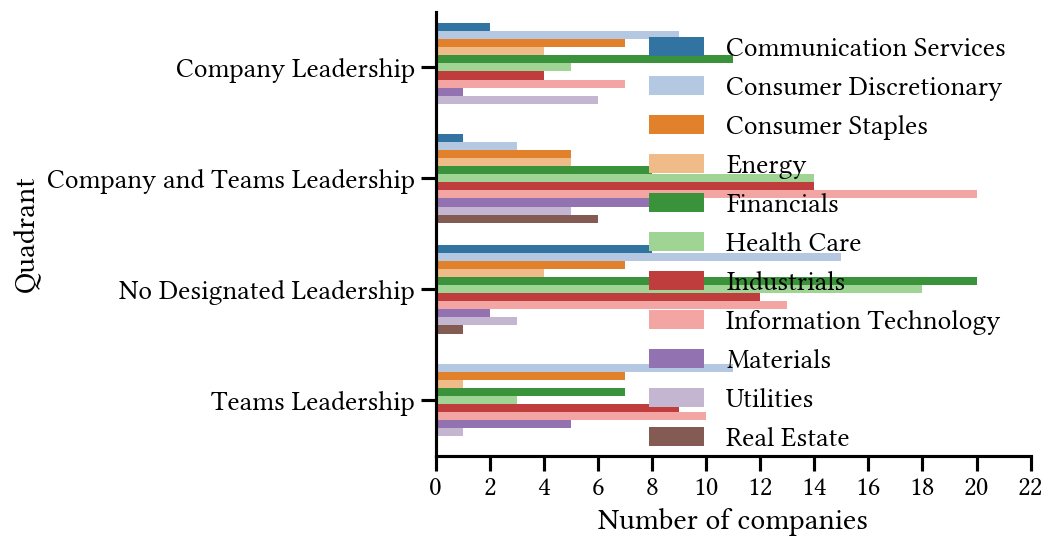

In [69]:
sns.barplot(
    x=0,
    y='quadrant',
    hue='sector',
    data=company_df.groupby(['quadrant', 'sector']).size().reset_index(),
    palette='tab20'
)
plt.legend(frameon=False)
plt.xticks(np.arange(0, 23, 2))
# plt.yticks([0, 1, 2, 3], ['The Strugglers', 'The Silos', 'The Powerful', 'The Champions'])
plt.xlabel('Number of companies')
plt.ylabel('Quadrant')
sns.despine()
plt.savefig('figures/quadrant.pdf', bbox_inches='tight')

In [70]:
plt.rcParams['font.size'] = 10

In [71]:
data['LPS'].describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.95])

count    439163.000000
mean          0.084692
std           0.109100
min           0.000000
25%           0.000000
50%           0.000000
75%           0.159171
80%           0.178812
95%           0.301714
max           0.647961
Name: LPS, dtype: float64

In [72]:
# companies = company_df.query('sector == "Financials"').company_name.tolist()
# companies = ['aig', 'metlife']
# data.query('company_name in @companies').query('LPS > 0.31').sample(10)

In [73]:
sns.set_context('paper')

In [88]:
color_map = {
    'Communication Services': 'C0',
    'Consumer Discretionary': 'C1',
    'Consumer Staples': 'C2',
    'Energy': 'C3',
    'Financials': 'C4',
    'Health Care': 'C5',
    'Industrials': 'C6',
    'Information Technology': 'C7',
    'Materials': 'C8',
    'Utilities': 'C9',
}

In [190]:
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = ['Linux Libertine O']

/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

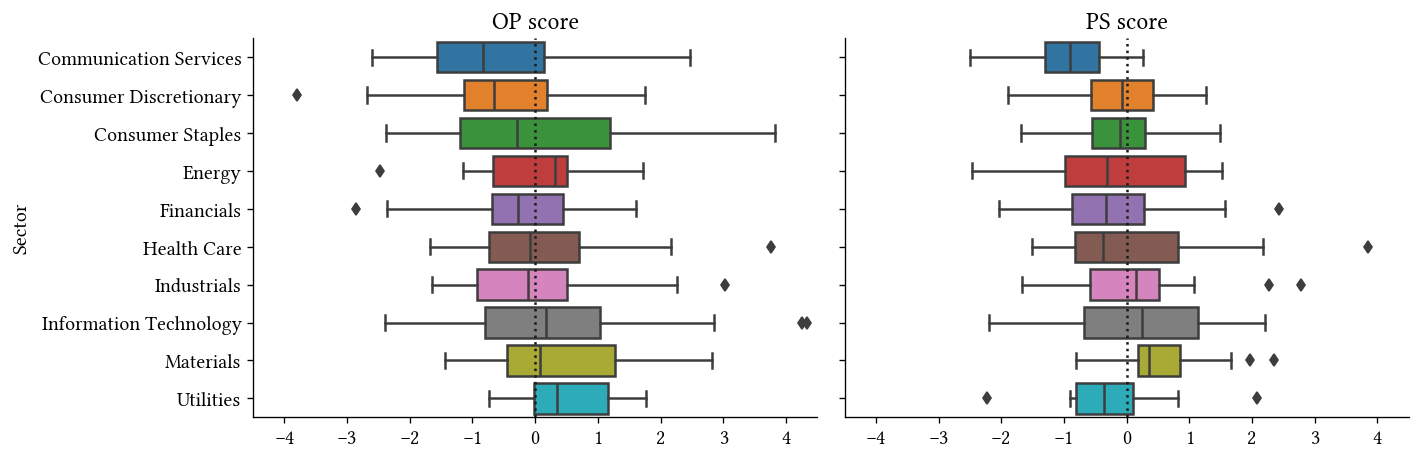

In [191]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharex=True, sharey=True)
for ax, col in zip(axes.flatten(), ['OP_score', 'PS_score']):
    sns.boxplot(
        x=col,
        y='sector',
        data=company_df.sort_values('sector').query('sector != "Real Estate"'),
        ax=ax
    )
    ax.axvline(0, linestyle=':', c='k')
    ax.set_xlabel('')
    ax.set_title(f"{col.replace('_', ' ')}")
axes[0].set_xlim(-4.5, 4.5)
axes[0].set_ylabel('Sector')
axes[1].set_ylabel('')
plt.tight_layout()
sns.despine()
plt.savefig('figures/op-ps-box.pdf', bbox_inches='tight')

/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

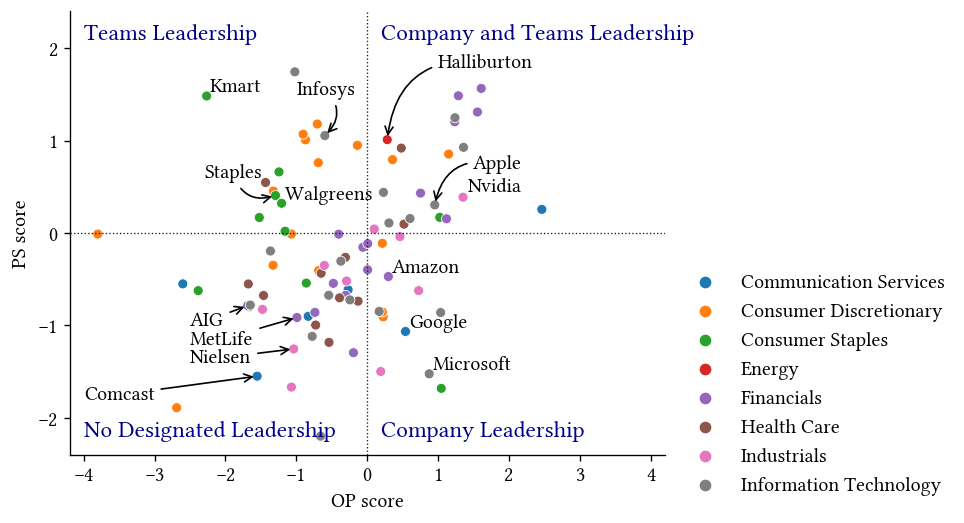

In [210]:
int_companies = [
    'amazon', 'apple', 'google', 'microsoft', 'nvidia',
    'infosys', 'comcast', 'metlife', 'aig',
    'nielsen', 'halliburton',
    'wallgreens', 'kmart', 'staples',
]

name_map = {
    'amazon': 'Amazon',
    'apple': 'Apple',
    'google': 'Google',
    'microsoft': 'Microsoft',
    'nvidia': 'Nvidia',
    'infosys': 'Infosys',
    'comcast': 'Comcast',
    'metlife': 'MetLife',
    'aig': 'AIG',
    'nielsen': 'Nielsen',
    'halliburton': 'Halliburton',
    'wallgreens': 'Walgreens',
    'kmart': 'Kmart',
    'staples': 'Staples',
}

sns.scatterplot(
    x='OP_score',
    y='PS_score',
    data=company_df.nlargest(100, 'n_reviews').sort_values('sector'),
    hue='sector',
    palette=color_map,
)
for idx, row in company_df.query('company_name in @int_companies').iterrows():
    if name_map[row['company_name']] == 'Staples':
        plt.annotate(
            name_map[row['company_name']],
            xy=(row['OP_score'], row['PS_score']),
            xytext=(-2.3, 0.6),
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle="arc3,rad=.5"
            )
        )
    elif name_map[row['company_name']] == 'Apple':
        plt.annotate(
            name_map[row['company_name']],
            xy=(row['OP_score'], row['PS_score']),
            xytext=(1.5, 0.7),
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle="arc3,rad=.5"
            )
        )
    elif name_map[row['company_name']] == 'AIG':
        plt.annotate(
            name_map[row['company_name']],
            xy=(row['OP_score'], row['PS_score']),
            xytext=(-2.5, -1),
            arrowprops=dict(arrowstyle='->')
        )
    elif name_map[row['company_name']] == 'MetLife':
        plt.annotate(
            name_map[row['company_name']],
            xy=(row['OP_score'], row['PS_score']),
            xytext=(-2.5, -1.2),
            arrowprops=dict(arrowstyle='->')
        )
    elif name_map[row['company_name']] == 'Nielsen':
        plt.annotate(
            name_map[row['company_name']],
            xy=(row['OP_score'], row['PS_score']),
            xytext=(-2.5, -1.4),
            arrowprops=dict(arrowstyle='->')
        )
    elif name_map[row['company_name']] == 'Comcast':
        plt.annotate(
            name_map[row['company_name']],
            xy=(row['OP_score'], row['PS_score']),
            xytext=(-4, -1.8),
            arrowprops=dict(arrowstyle='->')
        )
    elif name_map[row['company_name']] == 'Halliburton':
        plt.annotate(
            name_map[row['company_name']],
            xy=(row['OP_score'], row['PS_score']),
            xytext=(1, 1.8),
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle="arc3,rad=.5"
            )
        )
    elif name_map[row['company_name']] == 'Infosys':
        plt.annotate(
            name_map[row['company_name']],
            xy=(row['OP_score'], row['PS_score']),
            xytext=(-1, 1.5),
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle="arc3,rad=-.5"
            )
        )
    else:
        plt.annotate(name_map[row['company_name']], (row['OP_score'] + 5e-2, row['PS_score'] + 5e-2))
plt.legend(frameon=False, bbox_to_anchor=[1.5, 0.45])
plt.axhline(0, linestyle=':', c='k', linewidth=.8)
plt.axvline(0, linestyle=':', c='k', linewidth=.8)
plt.xlim(-4.2, 4.2)
plt.ylim(-2.4, 2.4)
plt.xlabel('OP score')
plt.ylabel('PS score')
plt.annotate('No Designated Leadership', (-4, -2.2), color='darkblue', fontsize=14)
plt.annotate('Teams Leadership', (-4, 2.1), color='darkblue', fontsize=14)
plt.annotate('Company Leadership', (0.2, -2.2), color='darkblue', fontsize=14)
plt.annotate('Company and Teams Leadership', (0.2, 2.1), color='darkblue', fontsize=14)
sns.despine()
plt.savefig('figures/cartesian.pdf', bbox_inches='tight')

In [75]:
company_df.groupby('sector').agg({
    'OP_score': 'std',
    'PS_score': 'std',
}).reset_index().sort_values('OP_score')

,sector,OP_score,PS_score
10,Utilities,0.755310,0.959719
4,Financials,0.982238,0.936355
1,Consumer Discretionary,1.056126,0.805567
6,Industrials,1.089861,0.910066
3,Energy,1.097370,1.177846
5,Health Care,1.156898,1.103509
8,Materials,1.285071,0.910008
0,Communication Services,1.406930,0.797193
7,Information Technology,1.461904,1.100224
2,Consumer Staples,1.583440,0.686568


In [76]:
company_df.query('sector == "Information Technology"').n_reviews.describe()

count       50.00000
mean      1663.16000
std       2374.16469
min        102.00000
25%        369.75000
50%        718.50000
75%       1274.75000
max      11299.00000
Name: n_reviews, dtype: float64

In [77]:
company_df.groupby('sector').size()

sector
Communication Services    11
Consumer Discretionary    38
Consumer Staples          26
Energy                    14
Financials                46
Health Care               40
Industrials               39
Information Technology    50
Materials                 17
Real Estate                7
Utilities                 15
dtype: int64

/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

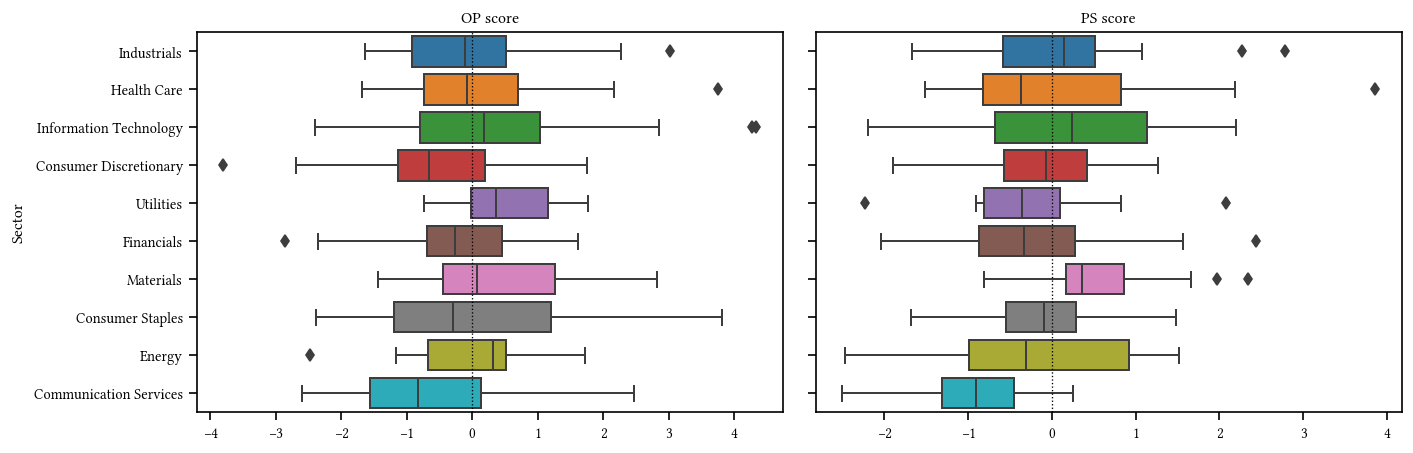

In [104]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
for ax, col in zip(axes.flatten(), ['OP_score', 'PS_score']):
    sns.boxplot(
        x=col,
        y='sector',
        data=company_df.query('sector != "Real Estate"'),
        ax=ax
    )
    ax.axvline(0, linestyle=':', c='k', linewidth=0.8)
    ax.set_xlabel('')
    ax.set_title(f"{col.replace('_', ' ')}")
axes[0].set_ylabel('Sector')
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig('figures/op-ps-box.pdf', bbox_inches='tight')

In [105]:
columns = company_df.filter(regex='rating_[overall|mgmt|comp]', axis=1).columns

In [161]:
from stargazer.stargazer import Stargazer
import statsmodels.formula.api as smf

results = []
# columns = company_df.filter(regex='rating_.*', axis=1).columns
columns = ['rating_career', 'rating_comp', 'rating_culture', 'rating_mgmt', 'rating_overall']
for y_col in columns:
    result = smf.ols(f'{y_col} ~ OP_score + PS_score + np.log(n_reviews)', data=company_df.merge(
        gd[['company', 'pct_stress']],
        how='left',
        left_on='company_name',
        right_on='company'
    )).fit()
    results.append(result)

In [162]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rating_overall   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     227.2
Date:                Sun, 07 Jan 2024   Prob (F-statistic):           2.40e-78
Time:                        22:19:13   Log-Likelihood:                 46.250
No. Observations:                 318   AIC:                            -84.50
Df Residuals:                     314   BIC:                            -69.45
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.0005      0.065     46.405      0.000       2.873       3.128
OP_score              0.2663      0.011     25.153      0.000       0.245       0.287
PS_score             -0.0607      0.013     -4.710      0.000      -0.086      -0.035
np.log(n_reviews)     0.0561      0.010      5.659      0.000       0.037       0.076
==============================================================================
Omnibus:                       11.072   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.381
Skew:                           0.411   Prob(JB):                      0.00338
Kurtosis:                       3.428   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
sg = Stargazer(results)
sg.custom_columns(columns, [1] * len(columns))
sg.show_model_numbers(False)

In [164]:
print(sg.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & \multicolumn{1}{c}{rating_career} & \multicolumn{1}{c}{rating_comp} & \multicolumn{1}{c}{rating_culture} & \multicolumn{1}{c}{rating_mgmt} & \multicolumn{1}{c}{rating_overall}  \\
\hline \\[-1.8ex]
 Intercept & 2.718$^{***}$ & 3.715$^{***}$ & 2.789$^{***}$ & 2.603$^{***}$ & 3.000$^{***}$ \\
& (0.065) & (0.085) & (0.081) & (0.068) & (0.065) \\
 OP_score & 0.251$^{***}$ & 0.292$^{***}$ & 0.290$^{***}$ & 0.276$^{***}$ & 0.266$^{***}$ \\
& (0.011) & (0.014) & (0.013) & (0.011) & (0.011) \\
 PS_score & -0.035$^{***}$ & -0.191$^{***}$ & -0.047$^{***}$ & -0.036$^{***}$ & -0.061$^{***}$ \\
& (0.013) & (0.017) & (0.016) & (0.013) & (0.013) \\
 np.log(n_reviews) & 0.077$^{***}$ & -0.041$^{***}$ & 0.079$^{***}$ & 0.053$^{***}$ & 0.056$^{***}$ \\
& (0.010) & (0.013) & (0.012) & (0.010) & (0.010) \\
\hline \\[-1.8ex]
 Observations & 318 & 318 & 318 & 318 & 318 \\
 $R^2$ & 0.67

In [275]:
company_df.groupby('sector').size().quantile(.25)

6.0

In [279]:
results = []
for sector, group in company_df.groupby('sector'):
    # if group.shape[0] < 14.5:
    #     continue
    result = smf.ols(f'rating_overall ~ OP_score + PS_score + np.log(n_reviews)', data=group.merge(
        gd[['company', 'pct_stress']],
        how='left',
        left_on='company_name',
        right_on='company'
    )).fit()
    results.append(result)

In [280]:
sectors = company_df['sector'].sort_values().unique().tolist()[:-1]
# sectors = list(np.array(sectors)[company_df.groupby('sector').size() > 14.5])
sg = Stargazer(results)
sg.custom_columns(sectors, [1] * len(sectors))
sg.show_model_numbers(False)

/Users/aliakbars/miniforge3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning: invalid value encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning: invalid value encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


In [281]:
sg

In [139]:
print(sg.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{8}{c}{\textit{Dependent variable:}} \
\cr \cline{8-9}
\\[-1.8ex] & \multicolumn{1}{c}{Consumer Discretionary} & \multicolumn{1}{c}{Consumer Staples} & \multicolumn{1}{c}{Financials} & \multicolumn{1}{c}{Health Care} & \multicolumn{1}{c}{Industrials} & \multicolumn{1}{c}{Information Technology} & \multicolumn{1}{c}{Materials} & \multicolumn{1}{c}{Utilities}  \\
\hline \\[-1.8ex]
 Intercept & 3.156$^{***}$ & 4.426$^{***}$ & 2.713$^{***}$ & 3.687$^{***}$ & 2.027$^{***}$ & 3.139$^{***}$ & 1.892$^{***}$ & 3.251$^{**}$ \\
  & (0.308) & (0.348) & (0.194) & (0.317) & (0.311) & (0.398) & (0.482) & (1.428) \\
 PS_score & 0.004$^{}$ & -0.067$^{}$ & 0.056$^{}$ & 0.152$^{***}$ & 0.255$^{***}$ & 0.010$^{}$ & 0.234$^{***}$ & 0.067$^{}$ \\
  & (0.076) & (0.108) & (0.037) & (0.044) & (0.059) & (0.063) & (0.070) & (0.091) \\
 np.log(n_reviews) & 0.010$^{}$ & -0.164$^{***}$ & 0

In [400]:
company_df[company_df.OP_score.gt(0.8) & company_df.PS_score.lt(-0.8)][['company_name', 'sector', 'n_reviews', 'OP_score', 'PS_score', 'rating_overall']].style.format(
    '{:.2f}',
    subset=['OP_score', 'PS_score', 'rating_overall']
)

,company_name,sector,n_reviews,OP_score,PS_score,rating_overall
4,adobe,Information Technology,842,1.43,-1.53,4.08
9,aflac,Financials,371,1.41,-0.91,3.46
23,ameren,Utilities,116,1.58,-2.24,3.50
67,centerpointenergy,Utilities,174,1.17,-0.89,3.67
90,costco,Consumer Staples,2911,1.04,-1.68,3.89
141,fidelity,Information Technology,3316,1.04,-0.87,3.68
239,mastercard,Information Technology,613,1.24,-1.17,3.80
250,microsoft,Information Technology,3311,0.88,-1.54,4.02


In [401]:
company_df[company_df.PS_score.gt(0.8) & company_df.OP_score.lt(-0.8)][['company_name', 'sector', 'n_reviews', 'OP_score', 'PS_score', 'rating_overall']].style.format(
    '{:.2f}',
    subset=['OP_score', 'PS_score', 'rating_overall']
)

,company_name,sector,n_reviews,OP_score,PS_score,rating_overall
6,advanceautoparts,Consumer Discretionary,1536,-0.91,1.06,2.91
108,dollargeneral,Consumer Discretionary,1730,-0.87,1.00,2.79
117,dxctechnology,Information Technology,375,-2.24,2.18,2.25
162,genuineparts,Consumer Discretionary,109,-0.98,0.94,3.03
164,globalpayments,Information Technology,125,-1.36,1.46,2.80
184,hpe,Information Technology,2126,-1.02,1.74,3.06
212,kmart,Consumer Staples,2564,-2.26,1.49,2.58
225,linde,Materials,202,-1.12,0.84,3.00


In [364]:
company_df.query('sector == "Communication Services"')[['company_name', 'OP_score', 'PS_score', 'rating_overall']].set_index('company_name').style.format('{:.2f}')

,OP_score,PS_score,rating_overall
company_name,,,
atandt,-0.84,-0.91,3.34
centurylink,-1.83,-0.35,2.85
comcast,-1.54,-1.54,3.26
discoveryinc,0.54,-0.33,3.52
dish,-2.60,-0.56,2.57
disney,-0.27,-0.62,3.74
electronicarts,-1.58,-2.51,3.50
facebook,2.46,0.24,4.51
google,0.54,-1.08,4.27


In [131]:
company_df['good_company'] = company_df['PC1'].gt(0)
company_df['good_team'] = company_df['PC2'].gt(0)

In [132]:
company_df.apply(lambda x: str(x['good_company']) + '-' + str(x['good_team']), axis=1).value_counts(True)

True-False     0.283208
False-True     0.268170
False-False    0.230576
True-True      0.218045
dtype: float64

In [ ]:
company_df['PC1_rank'] = pd.cut(company_df['PC1'], 20).cat.codes
company_df['PC2_rank'] = pd.cut(company_df['PC2'], 20).cat.codes
company_df['PC3_rank'] = pd.cut(company_df['PC3'], 20).cat.codes
company_df['PC4_rank'] = pd.cut(company_df['PC4'], 20).cat.codes
company_df['n_reviews_rank'] = pd.cut(company_df['n_reviews'], 20).cat.codes

In [203]:
company_df['PC1_rank'].value_counts().sort_index()

0       1
3       3
4       5
5      28
6      41
7     122
8     120
9      53
10     19
11      3
12      2
13      1
19      1
Name: PC1_rank, dtype: int64

In [200]:
company_df['PC2_rank'].value_counts().sort_index()

0      2
1      2
2      1
3      3
4      9
5     15
6     38
7     56
8     65
9     71
10    55
11    41
12    17
13     7
14     2
15     8
16     1
17     2
18     2
19     2
Name: PC2_rank, dtype: int64

In [205]:
# Good company, bad team
company_df[company_df['PC1_rank'].ge(10) & company_df['PC2_rank'].le(10)][['company_name', 'sector', 'n_reviews']]

,company_name,sector,n_reviews
3,abiomed,Health Care,66
18,alexandriarealestate,Real Estate,12
55,avalonbaycom,Real Estate,129
62,berkshirehathaway,Financials,38
68,bookingholdings,Consumer Discretionary,1
70,bostonproperties,Real Estate,48
75,brown-forman,Consumer Staples,126
123,crowncastle,Real Estate,92
132,dentsplysirona,Health Care,161
136,digitalrealty,Real Estate,148


In [244]:
# Good team, bad company
company_df[company_df['PC1_rank'].le(5) & company_df['PC2_rank'].ge(10)][['company_name', 'sector', 'n_reviews']]

,company_name,sector,n_reviews
25,amazon,Consumer Discretionary,3596
46,appliedmaterials,Information Technology,97
54,autozone,Consumer Discretionary,152
140,dish,Communication Services,3143
293,livenationentertainment,Communication Services,367
303,marines,NaN,1152
311,mcdonalds,Consumer Discretionary,335
373,petsmart,NaN,2416
385,starbucks,Consumer Discretionary,616
398,zte,Information Technology,39


In [473]:
company_df.groupby('sector').size().sort_values()

sector
Communication Services    16
Real Estate               17
Energy                    20
Materials                 21
Utilities                 21
Consumer Staples          34
Health Care               44
Consumer Discretionary    45
Industrials               51
Financials                53
Information Technology    62
dtype: int64

In [212]:
top_left = company_df[company_df['PC1_rank'].ge(10) & company_df['PC2_rank'].le(10)].company_name.values
bottom_right = company_df[company_df['PC1_rank'].le(5) & company_df['PC2_rank'].ge(10)].company_name.values

In [289]:
df.query('company_name in @bottom_right').sample(5, random_state=30)[['pros', 'cons']]

,pros,cons
368179,"While it wasn't for me long-term, Starbucks was a great place to work. I got along with most of the individuals on the team, the hours were flexible, the perks were nice, and the work wasn't terribly difficult.","When it's busy, you have to work fast! They try to train you well but it is a lot to take in and the other workers will grow tired of 'reteaching' you. My advice is to make a couple of close friends there so they can remind you of the procedures should you forget. Also, some of the shift managers could be difficult to work with."
307146,Good compensation package for the first 4 years. After that comp drops off because the stock grants are cut back to prevent the employee from exceeding the target comp. This effectively means the employee does not share in the success of the company. Very smart people with good ideas Great place to learn and develop,"Very competitive, aggressive and combative environment. Leadership uses threats and intimidation to motivate productivity. Not much team work. Sr leadership seems to be unable to prioritize. Efforts are redirected weekly to new deliverables in a very reactive way."
159641,You work. Not much more said.,"They set you up to fail. It is all numbers to them. When you fulfill their new terms they up the stakes and eventually you cannot complete unless you cheat. Turnover on employees is very high and many loyal workers for years would be let go for reasons that are not understood,"
306726,"Ownership, meaningful work, great teams, substantial vision. It feels like you’re making an actual impact working here.",Unrealistic deadlines cause unnecessary stress
69018,Offers great benefits even to part time employees Managers cared about my well-being and success Decent weekly tips,Very trying dealing with customers all day Early mornings if you are opening
